In [1]:
# import os
# os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
# Helpful statement for debugging, prints the thing entered as x and the output, i.e.,
# debugPrint(1+1) will output '1+1 [int] = 2'
import inspect
import re
def debugPrint(x):
    frame = inspect.currentframe().f_back
    s = inspect.getframeinfo(frame).code_context[0]
    r = re.search(r"\((.*)\)", s).group(1)
    print("{} [{}] = {}".format(r,type(x).__name__, x))
    
    
import os
import os, sys
# sys.path.append(os.path.join('~/dev/pytorchSPH/', "lib"))
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from tqdm.notebook import trange, tqdm
import yaml
%matplotlib notebook
import warnings
warnings.filterwarnings(action='once')
from datetime import datetime

import torch
from torch_geometric.nn import radius
from torch_geometric.nn import SplineConv, fps, global_mean_pool, radius_graph, radius
from torch_scatter import scatter

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

import tomli
from scipy.optimize import minimize
import matplotlib.patches as patches
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm
from matplotlib.ticker import MaxNLocator
import matplotlib.ticker as mticker

import torch
# import torchvision.models as models
from torch.profiler import profile, record_function, ProfilerActivity

<IPython.core.display.Javascript object>


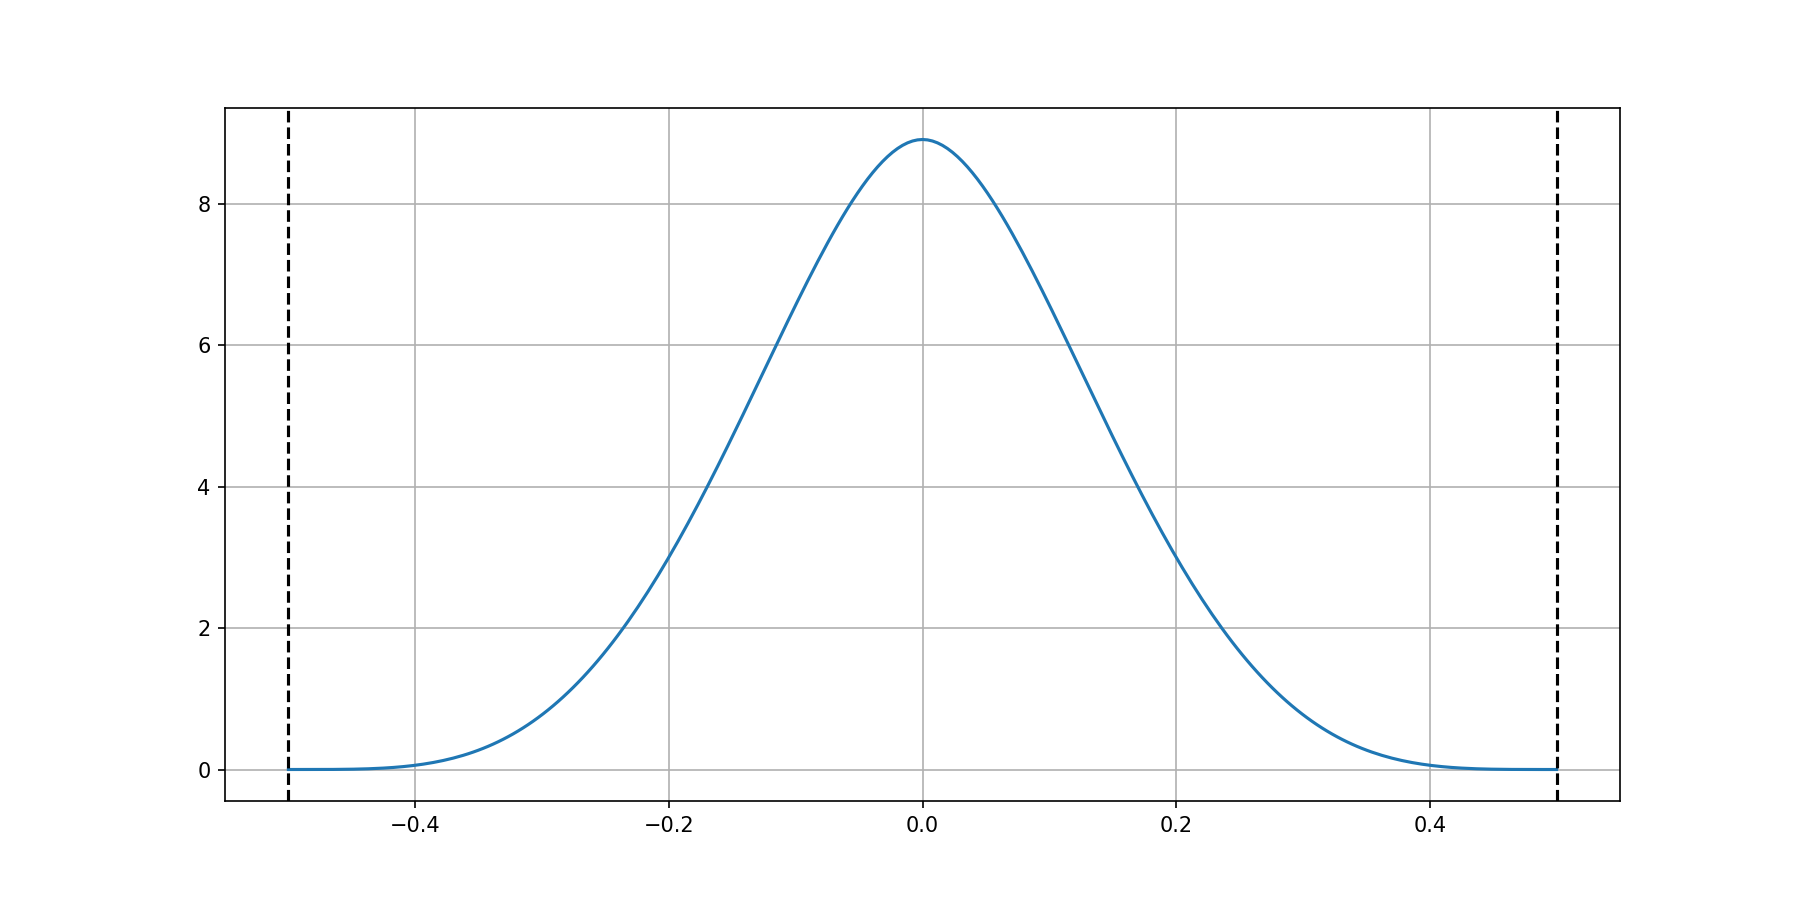

In [2]:
@torch.jit.script
def kernel(q, h):
    C = 7 / np.pi
    b1 = torch.pow(1. - q, 4)
    b2 = 1.0 + 4.0 * q
    return b1 * b2 * C / h**2    
@torch.jit.script
def kernelGradient(q,r,h):
    C = 7 / np.pi    
    return - r * C / h**3 * (20. * q * (1. -q)**3)[:,None]

h = 0.5
fig, axis = plt.subplots(1, 1, figsize=(12,6), sharex = False, sharey = False, squeeze = False)

x = torch.linspace(-h, h, 255)
fx = kernel(torch.abs(x) / h, h)

axis[0,0].plot(x, fx)
axis[0,0].axvline(h, ls = '--', c = 'black')
axis[0,0].axvline(-h, ls = '--', c = 'black')
axis[0,0].grid()


In [3]:
minCoord = -1
maxCoord = 1
dx = 0.05
# dx = 0.01
jitterCutoff = 0.9
jitterMagnitude = 1 * dx * 0.1


# Compute quantities
area = (dx)**2
h = np.sqrt(50 / np.pi * area)
Nh = np.pi * h**2 / area

# Physical Quantities
umax = 1
c0 = 10 * umax
CFL = 1.5
dt = CFL * h / c0
Ma = umax / c0

print('dx:', dx)
print('h:', h)
print('h/dx:', h/dx)
print('Nh:', Nh)

print('umax', 1, 'c0', c0)
print('dt', dt, 'Ma', Ma)

dx: 0.05
h: 0.19947114020071635
h/dx: 3.989422804014327
Nh: 49.99999999999999
umax 1 c0 10
dt 0.029920671030107454 Ma 0.1


In [17]:
# Particle generation
x = minCoord + torch.arange(np.ceil((maxCoord - minCoord)/dx)+1) * dx
y = minCoord + torch.arange(np.ceil((maxCoord - minCoord)/dx)+1) * dx
xx,yy = torch.meshgrid(x,y, indexing = 'xy')
positions = torch.vstack((xx.flatten(),yy.flatten())).mT

# Spherification
positions = positions[torch.linalg.norm(positions, dim = 1) < maxCoord,:]

# Jitter
centralParticles = torch.linalg.norm(positions,dim=1) < maxCoord * jitterCutoff
nCenter = torch.sum(centralParticles)
# positions[centralParticles,:] += torch.normal(torch.zeros((nCenter,2)),torch.ones((nCenter,2)) * jitterMagnitude *(maxCoord - torch.linalg.norm(positions[centralParticles],dim=1))[:,None])
positions[centralParticles,:] += torch.normal(torch.zeros((nCenter,2)),torch.ones((nCenter,2)) * jitterMagnitude )

numParticles = positions.shape[0]

In [149]:
# sph basic functionionality
# @torch.jit.script
def neighborhood(positions, h):
    j, i = radius(positions, positions, h,max_num_neighbors = 1000)
    cartesianDistances = positions[j] - positions[i]
    radialDistances = torch.linalg.norm(cartesianDistances, dim = 1) / h
    cDistances = cartesianDistances / ((radialDistances * h)[:,None] + 0.0001 * h**2)
    
    return i, j, radialDistances, cDistances, cartesianDistances 

In [19]:
# # basic plot to verify configuration
# i, j, radialDistances, cartesianDistances, rij = neighborhood(positions, h)
# rho = scatter(area * kernel(radialDistances, h), i, dim = 0, dim_size = numParticles, reduce = 'sum')
# neighs = scatter(torch.ones_like(radialDistances), i, dim = 0, dim_size = numParticles, reduce = 'sum')

In [20]:
# fig, axis = plt.subplots(1, 2, figsize=(12,6), sharex = False, sharey = False, squeeze = False)

# sc = axis[0,0].scatter(positions[:,0], positions[:,1], c = rho)
# axis[0,0].axis('equal')
# ax1_divider = make_axes_locatable(axis[0,0])
# cax1 = ax1_divider.append_axes("right", size="4%", pad="1%")
# cbar = fig.colorbar(sc, cax=cax1,orientation='vertical')
# cbar.ax.tick_params(labelsize=8)

# sc = axis[0,1].scatter(positions[:,0], positions[:,1], c = neighs)
# axis[0,1].axis('equal')
# ax1_divider = make_axes_locatable(axis[0,1])
# cax1 = ax1_divider.append_axes("right", size="4%", pad="1%")
# cbar = fig.colorbar(sc, cax=cax1,orientation='vertical')
# cbar.ax.tick_params(labelsize=8) 

# fig.tight_layout()

In [21]:
print(np.sqrt(np.pi))

1.7724538509055159


In [22]:
# import scipy.integrate as integrate

# h = 1/3
# delta = 3 * h
# integral = integrate.quad(lambda x: x * (np.exp(-(x/h)**2) - np.exp(-(delta/h)**2)),0,delta)[0]

# # integral = integrate.quad(lambda x:  x / (np.pi * h**2) * np.exp(-(x/h)**2),0,1)[0]
# print('integral:', integral)

# def gaussian(s,h):
#     return 1 / (np.pi * h**2) * np.exp(-(s/h)**2)

# def gaussian2(s,h,delta):
#     return (np.exp(-(s/h)**2) - np.exp(-(delta/h)**2)) / (2 * np.pi * integral)

# C =  (2 * np.pi * integral)
# correctionFactor = - np.exp(-(3)**2) / C
# def gaussianRenorm(q,h):
#     return (np.exp(-(q)**2)) / C + correctionFactor

# fig, axis = plt.subplots(1, 1, figsize=(12,6), sharex = False, sharey = False, squeeze = False)

# x = torch.linspace(-3 * h, 3 * h, 255)
# fx = gaussian(torch.abs(x), h)
# axis[0,0].plot(x, fx, label = 'gaussian')

# # fx = gaussian2(torch.abs(x), h, delta)
# # axis[0,0].plot(x, fx)

# hActual = 1
# fx = gaussianRenorm(torch.abs(x)/(hActual / 3), hActual)
# axis[0,0].plot(x, fx, label = 'gaussian renorm')

# print(integrate.quad(lambda x: gaussian(x, h), 0, delta))
# print(integrate.quad(lambda x: gaussian2(x, h, delta), 0, delta))
# print(integrate.quad(lambda x: gaussianRenorm(x / (hActual / 3), hActual), 0, hActual))
# print(integrate.quad(lambda x: kernel(x / hActual, hActual), 0, hActual))

# x = torch.linspace(-hActual,hActual, 255)
# fx = kernel(torch.abs(x), hActual)
# axis[0,0].plot(x, fx, label = 'wendland')

# axis[0,0].axvline(3 * h, ls = '--', c = 'black')
# axis[0,0].axvline(-3 * h, ls = '--', c = 'black')
# axis[0,0].grid()

# axis[0,0].legend()

In [23]:
# volume = area / rho

In [24]:

@torch.jit.script
def pinv2x2(M):
    with record_function('Pseudo Inverse 2x2'):
        a = M[:,0,0]
        b = M[:,0,1]
        c = M[:,1,0]
        d = M[:,1,1]

        theta = 0.5 * torch.atan2(2 * a * c + 2 * b * d, a**2 + b**2 - c**2 - d**2)
        cosTheta = torch.cos(theta)
        sinTheta = torch.sin(theta)
        U = torch.zeros_like(M)
        U[:,0,0] = cosTheta
        U[:,0,1] = - sinTheta
        U[:,1,0] = sinTheta
        U[:,1,1] = cosTheta

        S1 = a**2 + b**2 + c**2 + d**2
        S2 = torch.sqrt((a**2 + b**2 - c**2 - d**2)**2 + 4* (a * c + b *d)**2)

        o1 = torch.sqrt((S1 + S2) / 2)
        o2 = torch.sqrt((S1 - S2) / 2)

        phi = 0.5 * torch.atan2(2 * a * b + 2 * c * d, a**2 - b**2 + c**2 - d**2)
        cosPhi = torch.cos(phi)
        sinPhi = torch.sin(phi)
        s11 = torch.sign((a * cosTheta + c * sinTheta) * cosPhi + ( b * cosTheta + d * sinTheta) * sinPhi)
        s22 = torch.sign((a * sinTheta - c * cosTheta) * sinPhi + (-b * sinTheta + d * cosTheta) * cosPhi)

        V = torch.zeros_like(M)
        V[:,0,0] = cosPhi * s11
        V[:,0,1] = - sinPhi * s22
        V[:,1,0] = sinPhi * s11
        V[:,1,1] = cosPhi * s22


        o1_1 = torch.zeros_like(o1)
        o2_1 = torch.zeros_like(o2)

        o1_1[torch.abs(o1) > 1e-5] = 1 / o1[torch.abs(o1) > 1e-5] 
        o2_1[torch.abs(o2) > 1e-5] = 1 / o2[torch.abs(o2) > 1e-5] 
        o = torch.vstack((o1_1, o2_1))
        S_1 = torch.diag_embed(o.mT, dim1 = 2, dim2 = 1)

        eigVals = torch.vstack((o1, o2)).mT
        eigVals[torch.abs(eigVals[:,1]) > torch.abs(eigVals[:,0]),:] = torch.flip(eigVals[torch.abs(eigVals[:,1]) > torch.abs(eigVals[:,0]),:],[1])

        return torch.matmul(torch.matmul(V, S_1), U.mT), eigVals

    
@torch.jit.script
def computeNormalizationMatrix(i, j, rij, Vi, Vj, distances, radialDistances, support, numParticles : int, eps : float):
    gradW = kernelGradient(radialDistances, distances, support)

    r_ba = -rij #* support / 2
    fac = Vj[j]

#     term = torch.einsum('nu,nv -> nuv', r_ba, gradW)
#     term[:,0,0] = term[:,0,0] * fac
#     term[:,0,1] = term[:,0,1] * fac
#     term[:,1,0] = term[:,1,0] * fac
#     term[:,1,1] = term[:,1,1] * fac
    term = torch.zeros((r_ba.shape[0],2,2)).to(r_ba.device).type(r_ba.dtype)
    term[:,0,0] = gradW[:,0] * r_ba[:,0] * fac
    term[:,0,1] = gradW[:,0] * r_ba[:,1] * fac
    term[:,1,0] = gradW[:,1] * r_ba[:,0] * fac
    term[:,1,1] = gradW[:,1] * r_ba[:,1] * fac

    fluidNormalizationMatrix = scatter(term, i, dim=0, dim_size=numParticles, reduce = 'sum')
    return fluidNormalizationMatrix

In [26]:
# hTest = 0.03989422804014327
# # dx2 = hTest / 4.065
# # print(dx2)
# nS = 8
# dx2 = 2 * hTest / nS
# areaTest = dx2**2

# x = -hTest + torch.arange(nS + 1) * dx2
# y = -hTest + torch.arange(nS + 1) * dx2
# xx,yy = torch.meshgrid(x,y, indexing = 'xy')
# positions2 = torch.vstack((xx.flatten(),yy.flatten())).mT

# # Spherification
# positions2 = positions2[torch.linalg.norm(positions2, dim = 1) <= hTest,:]
# print(positions2.shape)
# volumeTest = areaTest / torch.ones(positions2.shape[0])
# testParticles = positions2.shape[0]

# # fig, axis = plt.subplots(1, 1, figsize=(18,6), sharex = False, sharey = False, squeeze = False)
# # scatterPlot(fig, axis[0,0], positions2, np.zeros(positions2.shape[0]))
# # fig.tight_layout()


In [27]:
# normalizationMatrices = computeNormalizationMatrix(torch.zeros(positions2.shape[0]).type(torch.long), torch.arange(positions2.shape[0]).type(torch.long), positions2, volumeTest, volumeTest, positions2 / (torch.linalg.norm(positions2,dim=1)[:,None] + 1e-4 * hTest**2), torch.linalg.norm(positions2, dim = 1) / hTest, hTest, testParticles, 1e-4)
# L, lambdas = pinv2x2(normalizationMatrices)
# Linv, invLambdas = pinv2x2(L)
# invLambdas = 1 / lambdas
# print('Linv', Linv[0])
# print('svd eigvals:', lambdas[0,:], invLambdas[0,:])
# print('L eigvals:', torch.linalg.eigvals(L[0,:,:]))
# print('Linv eigvals:', torch.linalg.eigvals(Linv[0,:,:]))

In [29]:
# print(volume)
# print(volumeTest)

In [30]:
# print(rij)

In [31]:
# print(area)
# print(1/h)

In [32]:

# volume = area / torch.ones_like(rho)
# normalizationMatrices = computeNormalizationMatrix(i, j, rij, volume, volume, cartesianDistances, radialDistances, h, numParticles, 1e-4)

# L, lambdas = pinv2x2(normalizationMatrices)
# Linv, invLambdas = pinv2x2(L)
# invLambdas = 1 / lambdas
# print('Linv', Linv[0])
# print('svd eigvals:', lambdas[0,:], invLambdas[0,:])
# print('L eigvals:', torch.linalg.eigvals(L[0,:,:]))
# print('Linv eigvals:', torch.linalg.eigvals(Linv[0,:,:]))

In [33]:
def scatterPlot(fig, axis, positions, data, title = ''):
    sc = axis.scatter(positions[:,0], positions[:,1], c = data, s = 8)
    axis.axis('equal')
    ax1_divider = make_axes_locatable(axis)
    cax1 = ax1_divider.append_axes("right", size="4%", pad="1%")
    cbar = fig.colorbar(sc, cax=cax1,orientation='vertical')
    cbar.ax.tick_params(labelsize=8)
    if title is not '':
        axis.set_title(title)

# fig, axis = plt.subplots(2, 3, figsize=(18,12), sharex = False, sharey = False, squeeze = False)
# B = torch.bmm(L, normalizationMatrices)
# B = normalizationMatrices
# ls = lambdas
# # B = L
# # ls = invLambdas
# scatterPlot(fig, axis[0,0], positions, B[:,0,0], 'L[:,0,0]')
# scatterPlot(fig, axis[0,1], positions, B[:,0,1], 'L[:,0,1]')
# scatterPlot(fig, axis[1,0], positions, B[:,1,0], 'L[:,1,0]')
# scatterPlot(fig, axis[1,1], positions, B[:,1,1], 'L[:,1,1]')
# scatterPlot(fig, axis[0,2], positions, ls[:,0], 'lambdas[:,1]')
# scatterPlot(fig, axis[1,2], positions, ls[:,1], 'lambdas[:,0]')
# fig.tight_layout()

In [146]:
torch.sqrt(torch.tensor(2))

tensor(1.4142)

In [147]:
@torch.jit.script
def computeTerm(i, j, Vi, Vj, distances, radialDistances, support, numParticles : int, eps : float):
    gradW = kernelGradient(radialDistances, distances, support)

    fac = Vj[j]

    fluidNormalizationMatrix = scatter(fac[:,None] * gradW, i, dim=0, dim_size=numParticles, reduce = 'sum')
    return fluidNormalizationMatrix

# sqrt2 = np.sqrt(2)

@torch.jit.script
def computeFreeSurface(i, j, positions, L, lambdas, volume, rij, cartesianDistances, radialDistances, h, numParticles):
    term = computeTerm(i, j, volume, volume, cartesianDistances, radialDistances, h, numParticles, 1e-4)

    nu = torch.bmm(L, term.unsqueeze(2))[:,:,0]
    n = nu / (torch.linalg.norm(nu, dim = 1) + 0.01 * h**2)[:,None]
    lMin = torch.min(torch.abs(lambdas), dim = 1)[0]
# #   Plot particle normals  
# #     fig, axis = plt.subplots(1, 3, figsize=(18,6), sharex = False, sharey = False, squeeze = False)
# #     mask = torch.logical_and(lMin > 0.25, lMin < 0.75)
# #     scatterPlot(fig, axis[0,0], positions[mask], n[mask,0], 'n.x')
# #     scatterPlot(fig, axis[0,1], positions[mask], n[mask,1], 'n.y')
# #     axis[0,2].quiver(positions[mask,0], positions[mask,1], n[mask,0], n[mask,1])
# #     axis[0,2].axis('equal')
# #     fig.tight_layout()

    T = positions + n * h / 3

    tau = torch.vstack((-n[:,1], n[:,0])).mT
    xji = -rij
    xjt = positions[j] - T[i]
    condA1 = torch.linalg.norm(xji, dim = 1) >= torch.sqrt(torch.tensor(2)) * h /3
    condA2 = torch.linalg.norm(xjt, dim = 1) < h / 3
    condA = torch.logical_and(torch.logical_and(condA1, condA2), i != j)
    cA = scatter(condA, i, dim=0, dim_size = numParticles, reduce = 'sum')
    condB1 = torch.linalg.norm(xji, dim = 1) < torch.sqrt(torch.tensor(2)) * h /3
    condB2 =  torch.abs(torch.einsum('nu,nu -> n', -n[i], xjt)) + torch.abs(torch.einsum('nu,nu -> n', tau[i], xjt)) < h / 3
    condB =  torch.logical_and(torch.logical_and(condB1, condB2), i != j)
    cB = scatter(condB, i, dim=0, dim_size = numParticles, reduce = 'sum')
    fs = torch.where(torch.logical_and(torch.logical_not(cA), torch.logical_not(cB)), torch.ones_like(lMin), torch.zeros_like(lMin))
#   Plot FS Conditions  
#     print('condition A1, true for: ', torch.sum(condA1), 'false for: ', torch.sum(torch.logical_not(condA1)), 'rate: %4.4g %%'% ((torch.sum(condA1) / condA1.shape[0]).numpy() * 100))
#     print('condition A2, true for: ', torch.sum(condA2), 'false for: ', torch.sum(torch.logical_not(condA2)), 'rate: %4.4g %%'% ((torch.sum(condA2) / condA2.shape[0]).numpy() * 100))
#     print('condition A, true for: ', torch.sum(condA), 'false for: ', torch.sum(torch.logical_not(condA)), 'rate: %4.4g %%'% ((torch.sum(condA) / condA.shape[0]).numpy() * 100))


#     print('condition B1, true for: ', torch.sum(condB1), 'false for: ', torch.sum(torch.logical_not(condB1)), 'rate: %4.4g %%'% ((torch.sum(condB1) / condB1.shape[0]).numpy() * 100))
#     print('condition B2, true for: ', torch.sum(condB2), 'false for: ', torch.sum(torch.logical_not(condB2)), 'rate: %4.4g %%'% ((torch.sum(condB2) / condB2.shape[0]).numpy() * 100))
#     print('condition B, true for: ', torch.sum(condB), 'false for: ', torch.sum(torch.logical_not(condB)), 'rate: %4.4g %%'% ((torch.sum(condB) / condB.shape[0]).numpy() * 100))

#     cA1 = scatter(condA1, i, dim=0, dim_size = numParticles, reduce = 'sum')
#     cA2 = scatter(condA2, i, dim=0, dim_size = numParticles, reduce = 'sum')
#     cB1 = scatter(condB1, i, dim=0, dim_size = numParticles, reduce = 'sum')
#     cB2 = scatter(condB2, i, dim=0, dim_size = numParticles, reduce = 'sum')

#     # fig, axis = plt.subplots(2, 3, figsize=(18,12), sharex = False, sharey = False, squeeze = False)
#     # scatterPlot(fig, axis[0,0], positions, torch.where(cA1, torch.ones(positions.shape[0]), torch.zeros(positions.shape[0])), 'condA1')
#     # scatterPlot(fig, axis[0,1], positions, torch.where(cA2, torch.ones(positions.shape[0]), torch.zeros(positions.shape[0])), 'condA2')
#     # scatterPlot(fig, axis[0,2], positions, torch.where(cA, torch.ones(positions.shape[0]), torch.zeros(positions.shape[0])), 'condA')
#     # scatterPlot(fig, axis[1,0], positions, torch.where(cB1, torch.ones(positions.shape[0]), torch.zeros(positions.shape[0])), 'condB1')
#     # scatterPlot(fig, axis[1,1], positions, torch.where(cB2, torch.ones(positions.shape[0]), torch.zeros(positions.shape[0])), 'condB2')
#     # scatterPlot(fig, axis[1,2], positions, torch.where(cB, torch.ones(positions.shape[0]), torch.zeros(positions.shape[0])), 'condB')

#     fig, axis = plt.subplots(1, 1, figsize=(6,6), sharex = False, sharey = False, squeeze = False)
#     scatterPlot(fig, axis[0,0], positions, torch.where(fs, torch.ones(positions.shape[0]), torch.zeros(positions.shape[0])), 'FS')
#     fig.tight_layout()
    
    return fs


In [ ]:
# 

In [35]:
# fs = computeFreeSurface(i,j, positions, L, lambdas, volume, rij, cartesianDistances, radialDistances, h, numParticles)
# fig, axis = plt.subplots(1, 3, figsize=(18,6), sharex = False, sharey = False, squeeze = False)
# scatterPlot(fig, axis[0,0], positions, torch.min(torch.abs(lambdas), dim = 1)[0] , 'lambda')
# scatterPlot(fig, axis[0,1], positions, torch.where(fs > 0, torch.ones(positions.shape[0]), torch.zeros(positions.shape[0])), 'Free Surface Marker')


# expandedFSM = scatter(fs[j], i, dim = 0, dim_size = numParticles, reduce = 'max')
# scatterPlot(fig, axis[0,2], positions, torch.where(expandedFSM > 0, torch.ones(positions.shape[0]), torch.zeros(positions.shape[0])), 'Expanded Surface Marker')
# fig.tight_layout()

In [36]:
fac = - Ma * (2 * h / 3) * c0 
print(fac)

@torch.jit.script
def computeShiftingTerm(i, j, Vi, Vj, distances, radialDistances, corr, support, numParticles : int, eps : float):
    R = 0.2
    n = 4
    W = kernel(radialDistances, support) / corr
    term = 1. + R * torch.pow(W, n)
    
    gradW = kernelGradient(radialDistances, distances, support)
    
    s = (Vj[j] * term)[:,None] * gradW
    fluidNormalizationMatrix = scatter(s, i, dim=0, dim_size=numParticles, reduce = 'sum')
    return fluidNormalizationMatrix

# du = computeShiftingTerm(i, j, volume, volume, cartesianDistances, radialDistances, kernel(dx / h, h), h, numParticles, 1e-4)
# du[expandedFSM > 0, :] = 0
# dr = dt * du
# torch.sum(du)
# print(du)

-0.1329807601338109


In [37]:

# i, j, radialDistances, cartesianDistances, rij = neighborhood(positions, h)

@torch.jit.script
def computeNormals(i, j, Vi, Vj, li, lj, Li, Lj, distances, radialDistances, support, numParticles : int, eps : float):
    
    gradW = kernelGradient(radialDistances, distances, support)
    kernelTerm = torch.bmm(Li[i], gradW.unsqueeze(2))[:,:,0]
    
    fac = Vj[j] * (lj[j] - li[i])
    term = -fac[:,None] * kernelTerm
    fluidNormalizationMatrix = scatter(term, i, dim=0, dim_size=numParticles, reduce = 'sum')
    return fluidNormalizationMatrix

In [152]:
@torch.jit.script
def computeShiftAmount(i, j, volume, lambdas, L, expandedFSM, cartesianDistances, radialDistances, h, numParticles, Ma, c0, dx):
    lMin = torch.min(torch.abs(lambdas), dim = 1)[0]
    gradLambda = computeNormals(i, j, volume, volume, lMin, lMin, L, L, cartesianDistances, radialDistances, h, numParticles, 1e-4)
    normals = gradLambda / (torch.linalg.norm(gradLambda, dim = 1) + 1e-4 * h**2)[:,None]

    normals[expandedFSM < 1,:] = 0
    kappa = torch.where(scatter(torch.arccos((normals[i] * normals[j]).sum(1)), i, dim = 0, dim_size = numParticles, reduce = 'max') >= 15 * np.pi/180, torch.zeros(numParticles), torch.ones(numParticles))
    fac = - Ma * (2 * h / 3) * c0 
#     Plot ev normals
#     mask = expandedFSM > 0

#     fig, axis = plt.subplots(1, 3, figsize=(18,6), sharex = False, sharey = False, squeeze = False)
#     scatterPlot(fig, axis[0,0], positions[mask], normals[mask,0] , 'dr.x')
#     scatterPlot(fig, axis[0,1], positions[mask], normals[mask,1] , 'dr.y')
#     scatterPlot(fig, axis[0,2], positions[mask], kappa[mask] , 'kappa')
#     fig.tight_layout()
    du = -fac * computeShiftingTerm(i, j, volume, volume, cartesianDistances, radialDistances, kernel(dx / h, h), h, numParticles, 1e-4)

    shiftTermA = torch.zeros_like(du)
    shiftTermB = kappa[:,None] * torch.bmm((torch.eye(2).reshape((1,2,2)).repeat(numParticles,1,1) - torch.einsum('nu, nv -> nuv', normals, normals)), du.unsqueeze(2))[:,:,0]
    shiftTermB = torch.bmm((torch.eye(2).reshape((1,2,2)).repeat(numParticles,1,1) - torch.einsum('nu, nv -> nuv', normals, normals)), du.unsqueeze(2))[:,:,0]
    shiftTermC = du

    prodTerm = -(normals * du).sum(1)
#     print(prodTerm[torch.logical_and(lMin >= 0.55, expandedFSM > 0)])
    lambdaThreshold = 0.55
    condA = torch.logical_and(lMin >= lambdaThreshold, torch.logical_and(prodTerm >= 0, expandedFSM > 0))
    condB = torch.logical_and(lMin >= lambdaThreshold, torch.logical_and(prodTerm < 0, expandedFSM > 0))
    condC = expandedFSM < 1
    
#     print(torch.max(prodTerm))

    shiftVelocity = shiftTermA
    shiftVelocity[condA,:] = shiftTermB[condA,:]
    shiftVelocity[condB,:] = du[condB,:]
    shiftVelocity[condC,:] = du[condC,:]
    
    return shiftVelocity, normals#, condA, condB, condC, kappa

# du, condA, condB, condC, kappa = computeShiftAmount(i, j, volume, lambdas, L, expandedFSM, cartesianDistances, radialDistances, h, numParticles)

In [126]:

# fig, axis = plt.subplots(1, 3, figsize=(18,6), sharex = False, sharey = False, squeeze = False)
# scatterPlot(fig, axis[0,0], positions, condA + condB * 2 + condC * 3 , 'dr.x')
# scatterPlot(fig, axis[0,1], positions, condA + 2 * condB , 'dr.y')
# scatterPlot(fig, axis[0,2], positions, kappa , 'dr.y')
# fig.tight_layout()

In [127]:
0.4287 * 0.2987 + 0.9034 * 0.9543

0.9901673100000001

In [128]:
# fac = - Ma * (2 * h / 3) * c0 
# du = -fac * computeShiftingTerm(i, j, volume, volume, cartesianDistances, radialDistances, kernel(dx / h, h), h, numParticles, 1e-4)

# shiftTermA = torch.zeros_like(du)
# shiftTermC = du

In [129]:
dx

0.05

In [130]:

# fig, axis = plt.subplots(1, 2, figsize=(18,6), sharex = False, sharey = False, squeeze = False)
# scatterPlot(fig, axis[0,0], positions, normals[:,0] , 'dr.x')
# scatterPlot(fig, axis[0,1], positions, normals[:,1] , 'dr.y')
# fig.tight_layout()

In [153]:
def shiftParticles(positions):
#     numParticles = int(numParticles)
    i, j, radialDistances, cartesianDistances, rij = neighborhood(positions, h)
    rho = scatter(area * kernel(radialDistances, h), i, dim = 0, dim_size = numParticles, reduce = 'sum')
    neighs = scatter(torch.ones_like(radialDistances), i, dim = 0, dim_size = numParticles, reduce = 'sum')
    volume = area / torch.ones_like(rho)
#     volume = area / rho
    normalizationMatrices = computeNormalizationMatrix(i, j, rij, volume, volume, cartesianDistances, radialDistances, h, numParticles, 1e-4)

    L, lambdas = pinv2x2(normalizationMatrices)
    Linv, invLambdas = pinv2x2(L)
    invLambdas = 1 / lambdas
    fs = computeFreeSurface(i,j, positions, L, lambdas, volume, rij, cartesianDistances, radialDistances, h, numParticles)
    expandedFSM = scatter(fs[j], i, dim = 0, dim_size = numParticles, reduce = 'max')
#     print(dx)
    du, normals = computeShiftAmount(i, j, volume, lambdas, L, expandedFSM, cartesianDistances, radialDistances, h, numParticles, Ma, c0, dx)
#     fac = - Ma * (2 * h / 3) * c0 
#     du = -fac * computeShiftingTerm(i, j, volume, volume, cartesianDistances, radialDistances, kernel(dx / h, h), h, numParticles, 1e-4)
#     du[expandedFSM > 0, :] = 0
#     print((torch.clamp(torch.linalg.norm(du, dim = 1), max = umax/2)))
#     print(torch.linalg.norm(du, dim = 1))

    dmag = torch.clamp(torch.linalg.norm(du, dim = 1), max = umax/2)
#     print(torch.linalg.norm(du, dim = 1))
#     print(dmag)
    du = (dmag / (torch.linalg.norm(du, dim = 1) + 1e-4 * h**2))[:,None] * du
#     print(du)
    dr = dt * du
    
    return dr

In [132]:
# (torch.clamp(torch.linalg.norm(du, dim = 1), max = umax/2) / torch.linalg.norm(du, dim = 1))[:,None] * du

In [133]:
def scatterPlot(fig, axis, positions, data, title = ''):
    sc = axis.scatter(positions[:,0], positions[:,1], c = data, s = 8)
    axis.axis('equal')
    ax1_divider = make_axes_locatable(axis)
    cax1 = ax1_divider.append_axes("right", size="4%", pad="1%")
    cbar = fig.colorbar(sc, cax=cax1,orientation='vertical')
    cbar.ax.tick_params(labelsize=8)
    if title is not '':
        axis.set_title(title)

<IPython.core.display.Javascript object>


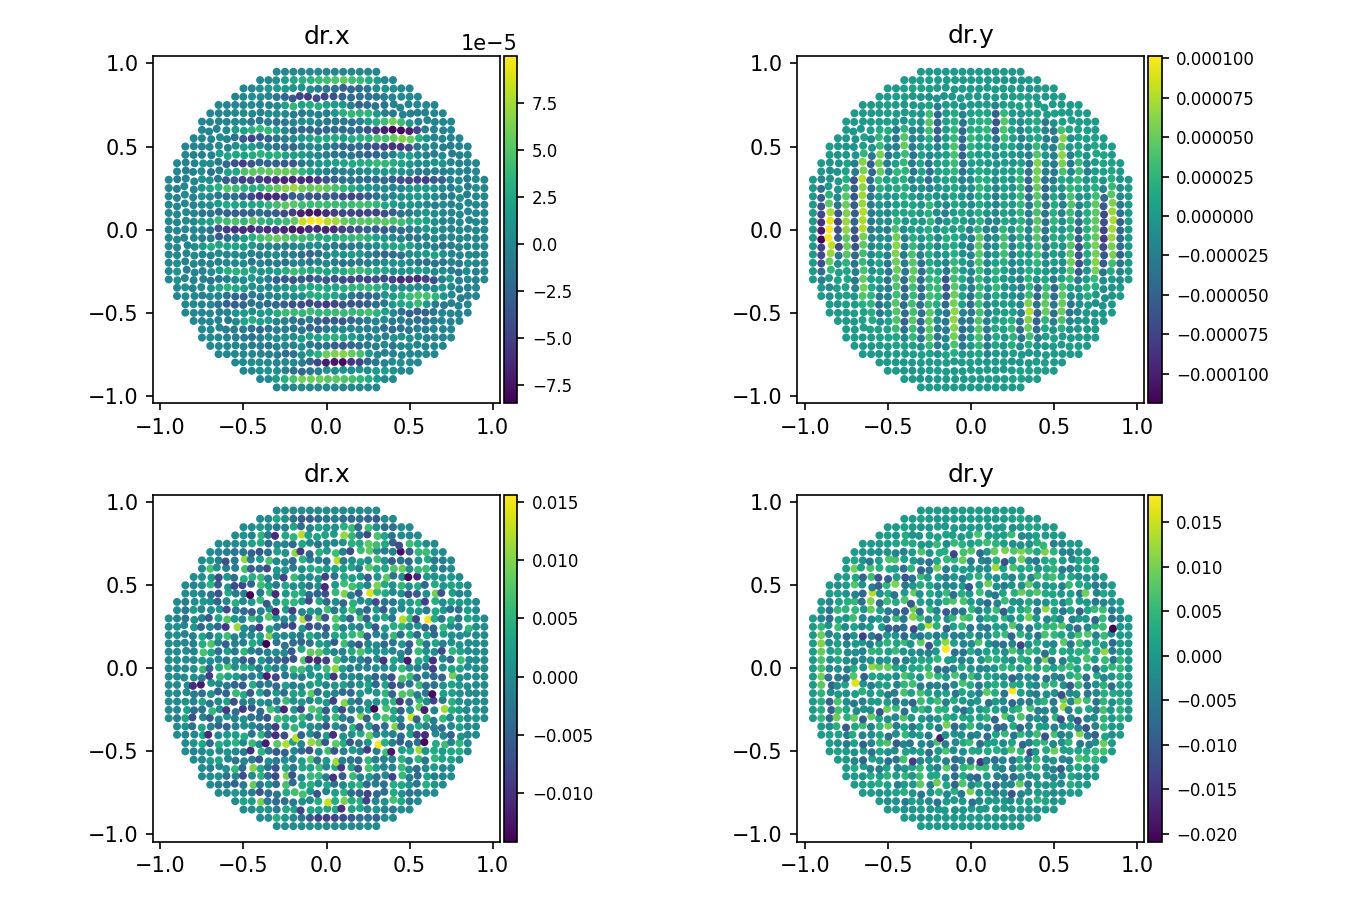

In [134]:
shiftedPositions = torch.clone(positions)
for shiftStep in range(64):
    shiftedPositions += shiftParticles(shiftedPositions)
    
dr = shiftParticles(shiftedPositions)
# print(dr)

fig, axis = plt.subplots(2, 2, figsize=(9,6), sharex = False, sharey = False, squeeze = False)
scatterPlot(fig, axis[0,0], shiftedPositions, dr[:,0] , 'dr.x')
scatterPlot(fig, axis[0,1], shiftedPositions, dr[:,1] , 'dr.y')

scatterPlot(fig, axis[1,0], positions, positions[:,0] - shiftedPositions[:,0], 'dr.x')
scatterPlot(fig, axis[1,1], positions, positions[:,1] - shiftedPositions[:,1], 'dr.y')
fig.tight_layout()

<IPython.core.display.Javascript object>


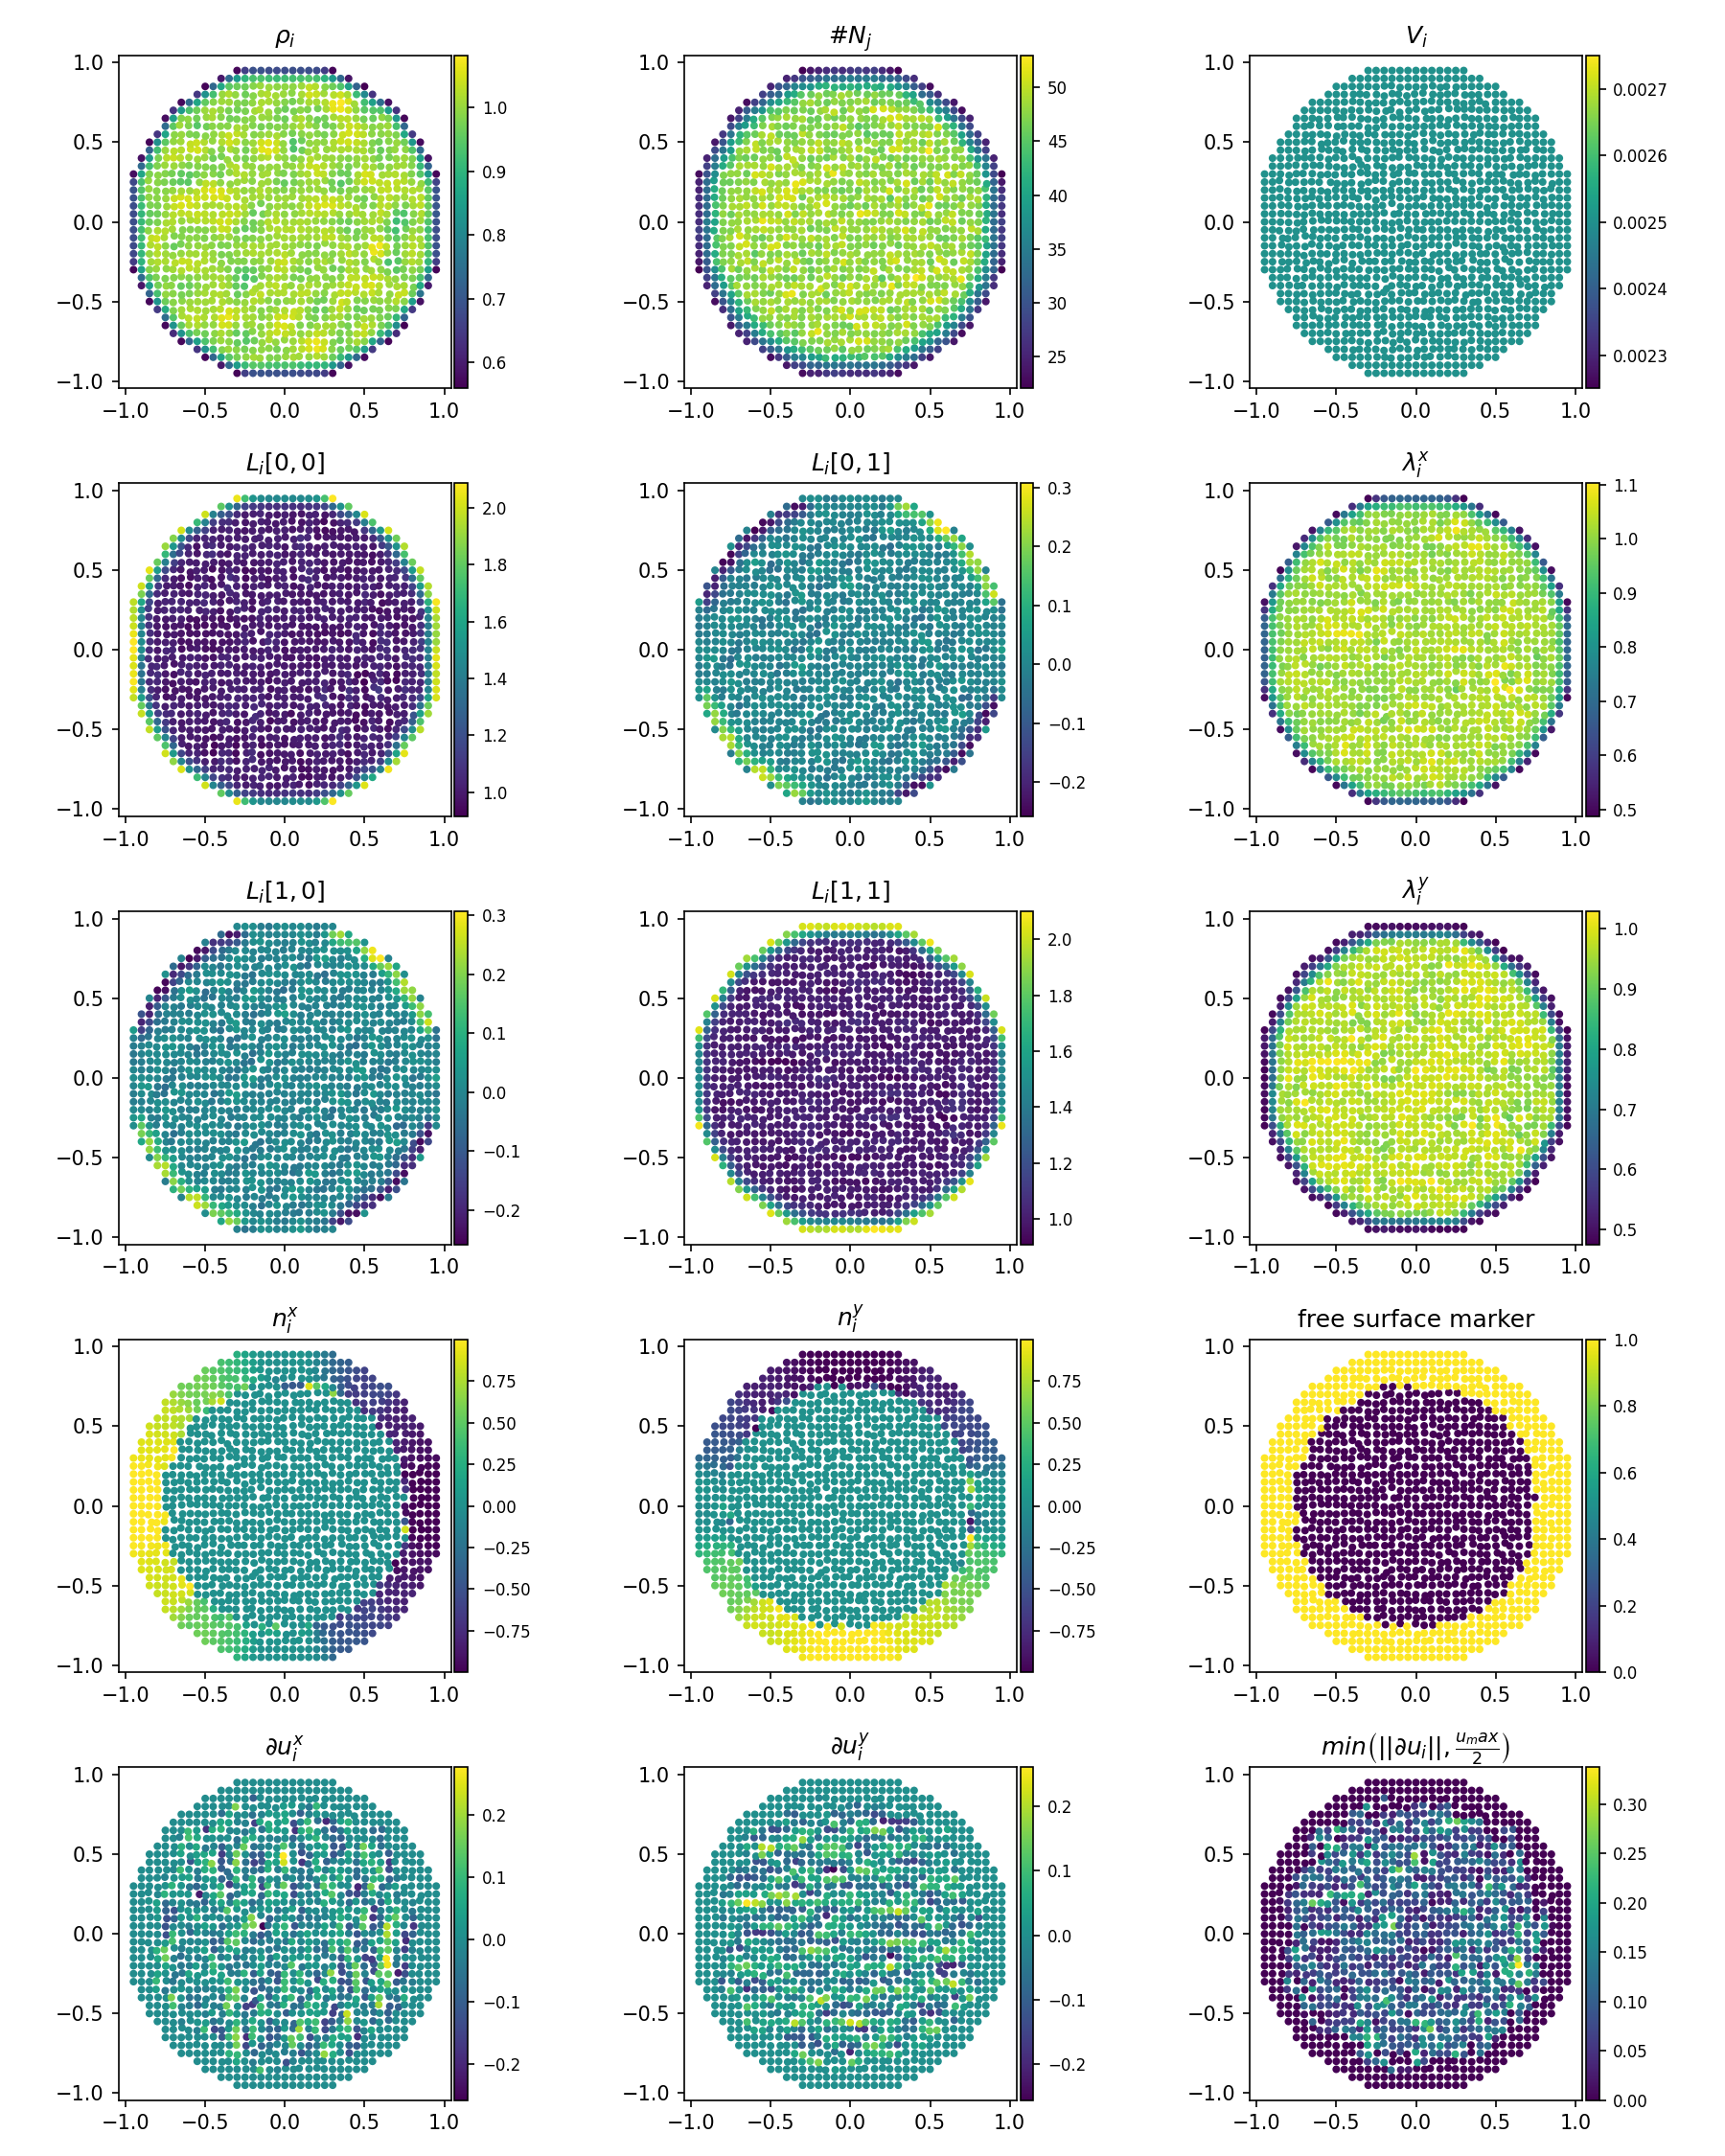

In [116]:
i, j, radialDistances, cartesianDistances, rij = neighborhood(positions, h)
rho = scatter(area * kernel(radialDistances, h), i, dim = 0, dim_size = numParticles, reduce = 'sum')
neighs = scatter(torch.ones_like(radialDistances), i, dim = 0, dim_size = numParticles, reduce = 'sum')
volume = area / torch.ones_like(rho)
# volume = area / rho
normalizationMatrices = computeNormalizationMatrix(i, j, rij, volume, volume, cartesianDistances, radialDistances, h, numParticles, 1e-4)

L, lambdas = pinv2x2(normalizationMatrices)
Linv, invLambdas = pinv2x2(L)
invLambdas = 1 / lambdas

fs = computeFreeSurface(i,j, positions, L, lambdas, volume, rij, cartesianDistances, radialDistances, h, numParticles)
expandedFSM = scatter(fs[j], i, dim = 0, dim_size = numParticles, reduce = 'max')
#     print(dx)
du, normals = computeShiftAmount(i, j, volume, lambdas, L, expandedFSM, cartesianDistances, radialDistances, h, numParticles)
dmag = torch.clamp(torch.linalg.norm(du, dim = 1), max = umax/2)
#     print(torch.linalg.norm(du, dim = 1))
#     print(dmag)
# du = (dmag / (torch.linalg.norm(du, dim = 1) + 1e-4 * h**2))[:,None] * du


fig, axis = plt.subplots(5, 3, figsize=(12,15), sharex = False, sharey = False, squeeze = False)

scatterPlot(fig, axis[0,0], positions, rho , r'$\rho_i$')
scatterPlot(fig, axis[0,1], positions, neighs , '#$N_j$')
scatterPlot(fig, axis[0,2], positions, volume , '$V_i$')

scatterPlot(fig, axis[1,0], positions, L[:,0,0] , '$L_i[0,0]$')
scatterPlot(fig, axis[1,1], positions, L[:,0,1] , '$L_i[0,1]$')
scatterPlot(fig, axis[1,2], positions, lambdas[:,0] , r'$\lambda_i^x$')

scatterPlot(fig, axis[2,0], positions, L[:,1,0] , '$L_i[1,0]$')
scatterPlot(fig, axis[2,1], positions, L[:,1,1] , '$L_i[1,1]$')
scatterPlot(fig, axis[2,2], positions, lambdas[:,1] , r'$\lambda_i^y$')

scatterPlot(fig, axis[3,0], positions, normals[:,0] , '$n_i^x$')
scatterPlot(fig, axis[3,1], positions, normals[:,1] , '$n_i^y$')
scatterPlot(fig, axis[3,2], positions, expandedFSM , 'free surface marker')
            
scatterPlot(fig, axis[4,0], positions, du[:,0] , r'$\partial u_i^x$')
scatterPlot(fig, axis[4,1], positions, du[:,1] , r'$\partial u_i^y$')
scatterPlot(fig, axis[4,2], positions, dmag , r'$min\left(||\partial u_i||, \frac{u_max}{2}\right)$')

#     fac = - Ma * (2 * h / 3) * c0 
#     du = -fac * computeShiftingTerm(i, j, volume, volume, cartesianDistances, radialDistances, kernel(dx / h, h), h, numParticles, 1e-4)
#     du[expandedFSM > 0, :] = 0
#     print((torch.clamp(torch.linalg.norm(du, dim = 1), max = umax/2)))
#     print(torch.linalg.norm(du, dim = 1))

dmag = torch.clamp(torch.linalg.norm(du, dim = 1), max = umax/2)

fig.tight_layout()

In [1094]:
kernel(dx/h, h)

tensor(35.3592, dtype=torch.float64)

<IPython.core.display.Javascript object>


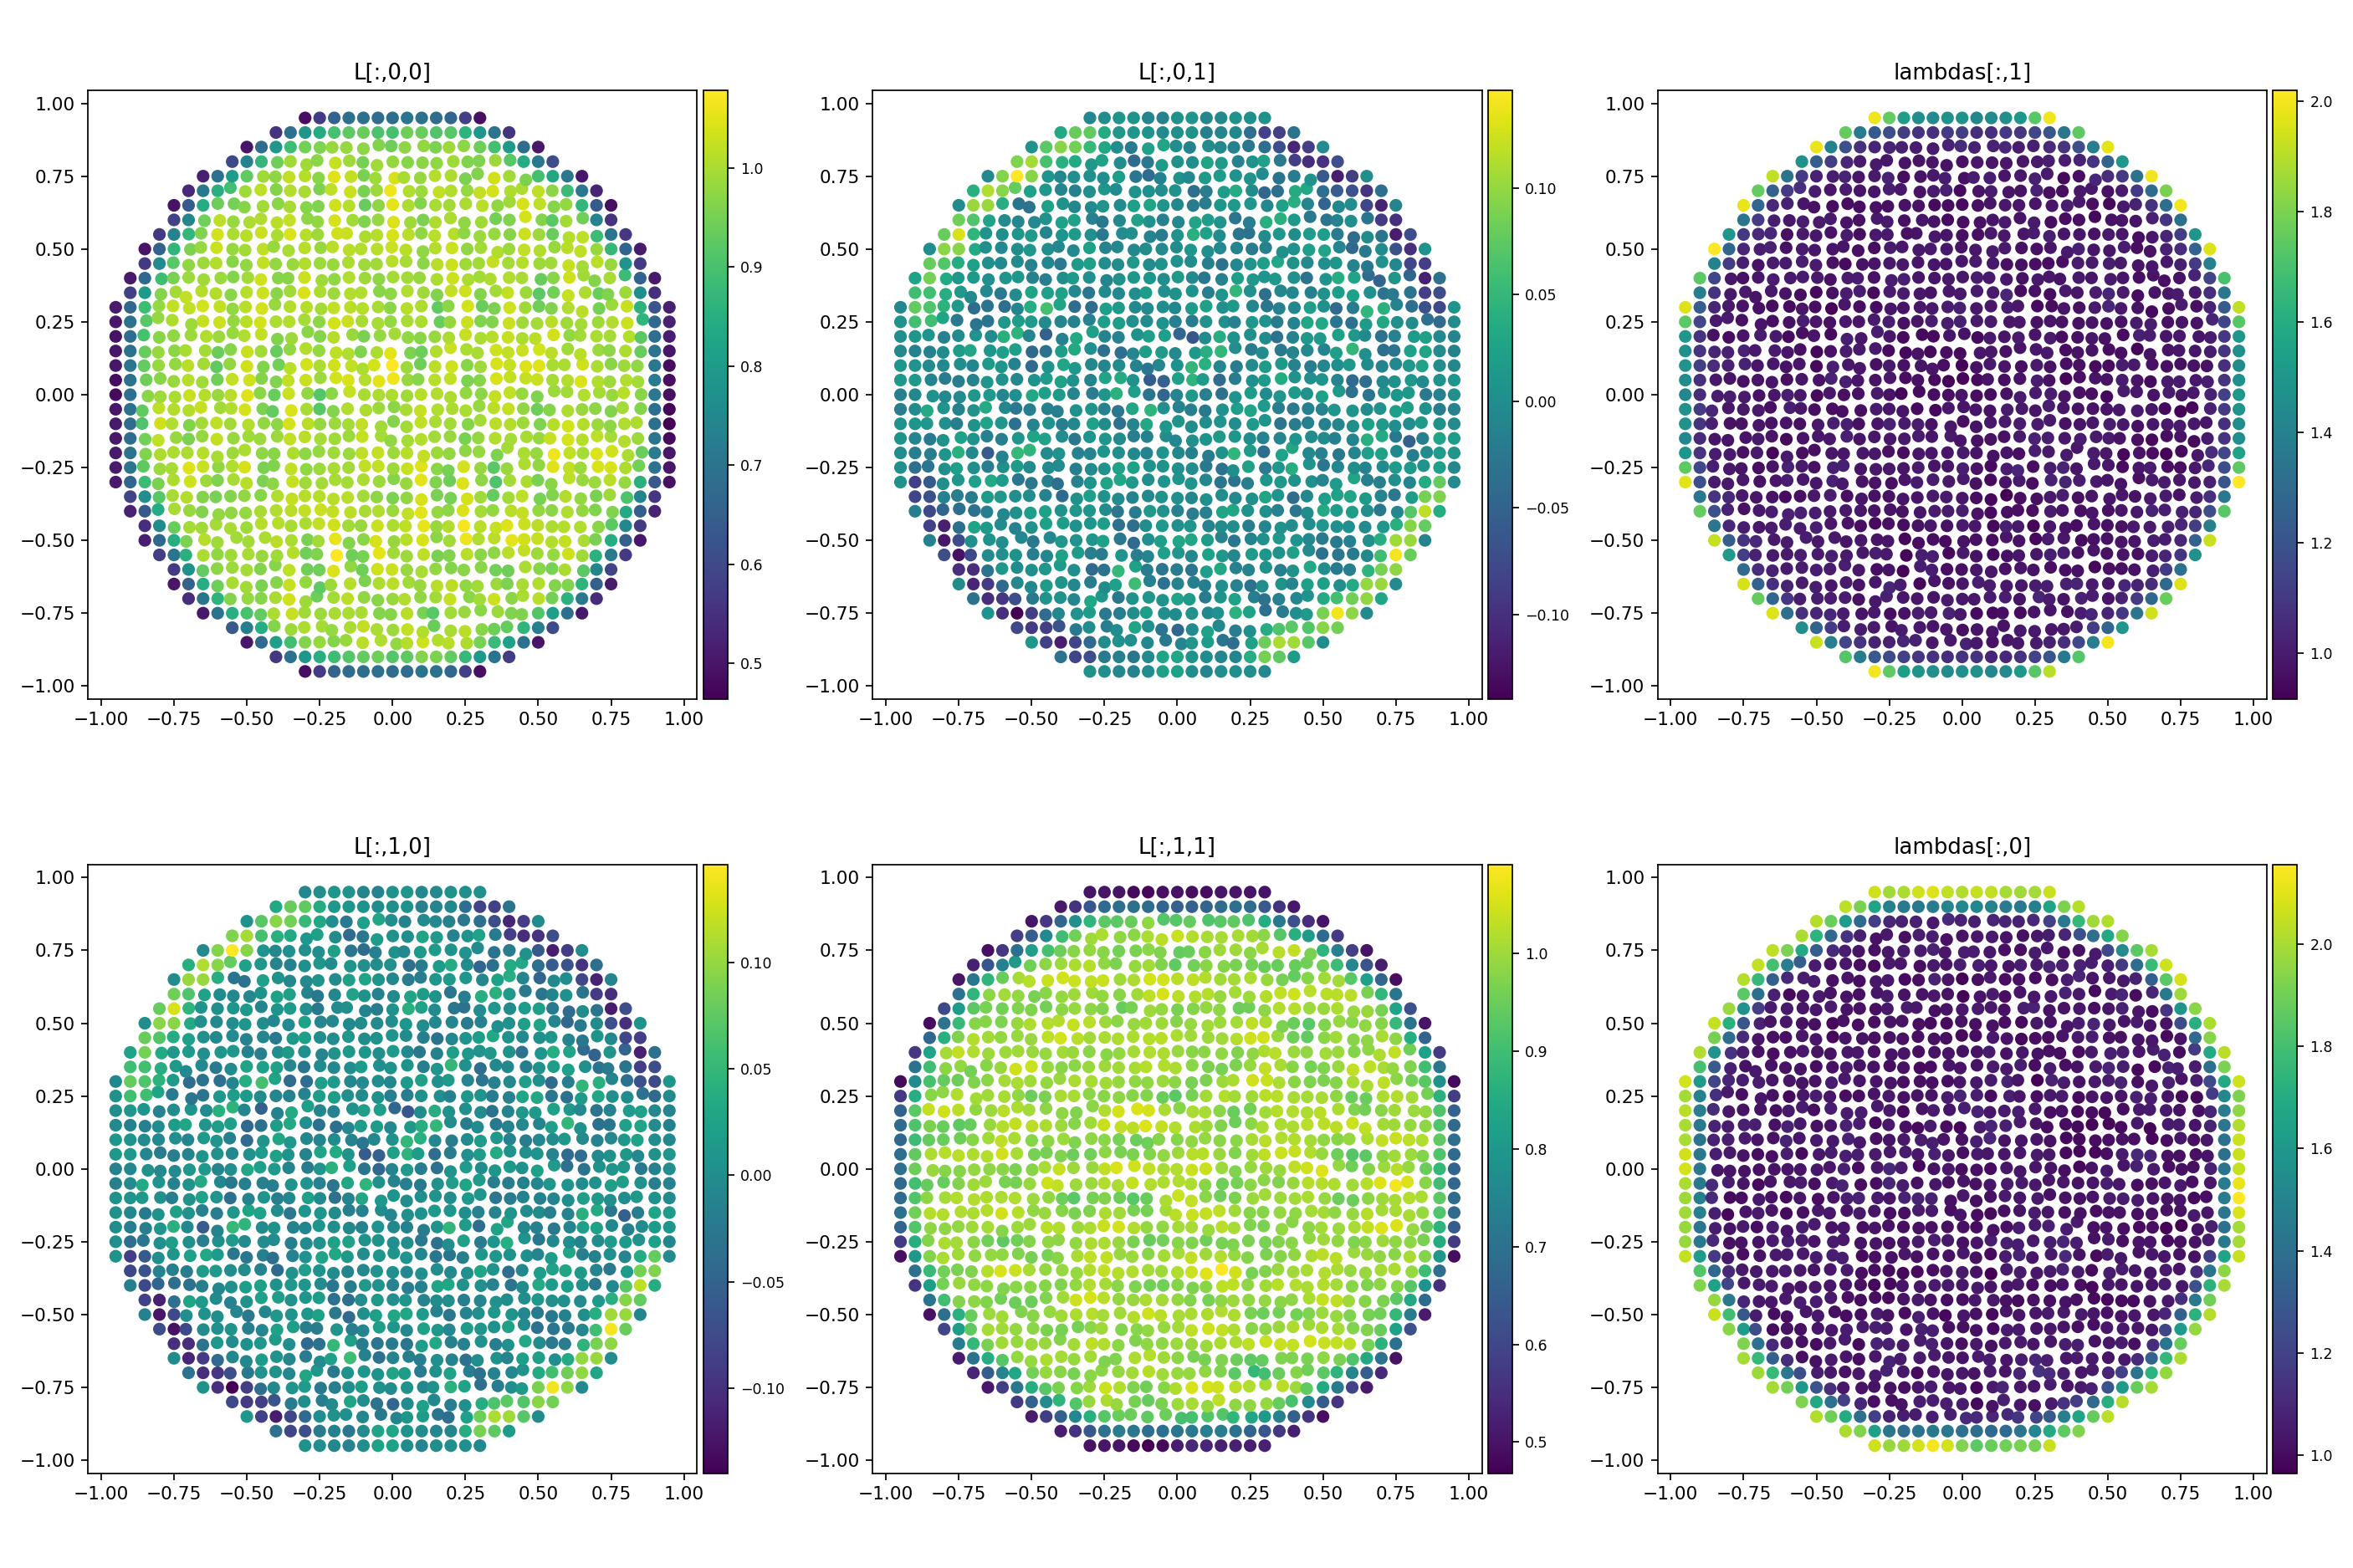

In [1095]:
fig, axis = plt.subplots(2, 3, figsize=(18,12), sharex = False, sharey = False, squeeze = False)
def scatterPlot(fig, axis, positions, data, title = ''):
    sc = axis.scatter(positions[:,0], positions[:,1], c = data)
    axis.axis('equal')
    ax1_divider = make_axes_locatable(axis)
    cax1 = ax1_divider.append_axes("right", size="4%", pad="1%")
    cbar = fig.colorbar(sc, cax=cax1,orientation='vertical')
    cbar.ax.tick_params(labelsize=8)
    if title is not '':
        axis.set_title(title)
B = torch.bmm(L, normalizationMatrices)
B = normalizationMatrices
ls = lambdas
# B = L
ls = invLambdas
scatterPlot(fig, axis[0,0], positions, B[:,0,0], 'L[:,0,0]')
scatterPlot(fig, axis[0,1], positions, B[:,0,1], 'L[:,0,1]')
scatterPlot(fig, axis[1,0], positions, B[:,1,0], 'L[:,1,0]')
scatterPlot(fig, axis[1,1], positions, B[:,1,1], 'L[:,1,1]')
scatterPlot(fig, axis[0,2], positions, ls[:,0], 'lambdas[:,1]')
scatterPlot(fig, axis[1,2], positions, ls[:,1], 'lambdas[:,0]')
fig.tight_layout()